## California Housing DataSet


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
    
california = fetch_california_housing()

# EXPLORATORY DATA ANALYSIS

In [2]:
# First thing we'll do is exploring our data set. In every scikit Dataset there's a DESCR atribute with the description of the dataset.

print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

There's one thing that it's not said in DESCR, and it's that target value corresponds to the average house value in units of 100,000.

In [3]:
# For EDA, we'll use pandas API, so we'll transform numpy arrays in pandas dataframes

concat_california_array = np.concatenate((california.data, np.reshape(california.target, (california.target.shape[0],1))), axis = 1)

california_df = pd.DataFrame(concat_california_array, columns = california.feature_names + ['price'])

california_df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521


## GEOSPATIAL PLOT

Houses near to the ocean should have higher prices than inland ones. We'll make a scatter plot to corroborate our hypothesis.

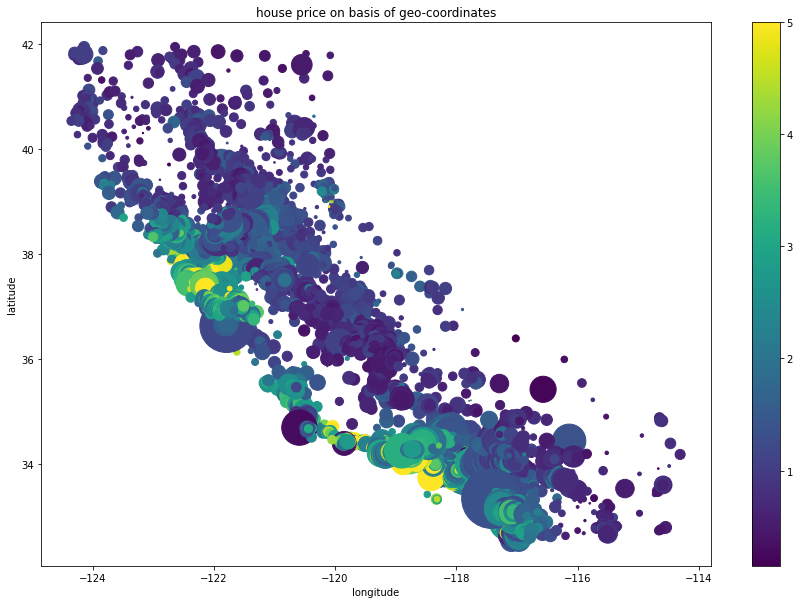

In [4]:
plt.figure(figsize=(15,10))

# We divide population by ten to scale bubble sizes.

plt.scatter(california_df['Longitude'],california_df['Latitude'],c=california_df['price'],s=california_df['Population']/10,cmap='viridis')
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('house price on basis of geo-coordinates')
plt.show()

So that's true, houses along the coast have higher values, as expected.

## CORRELATION MATRIX

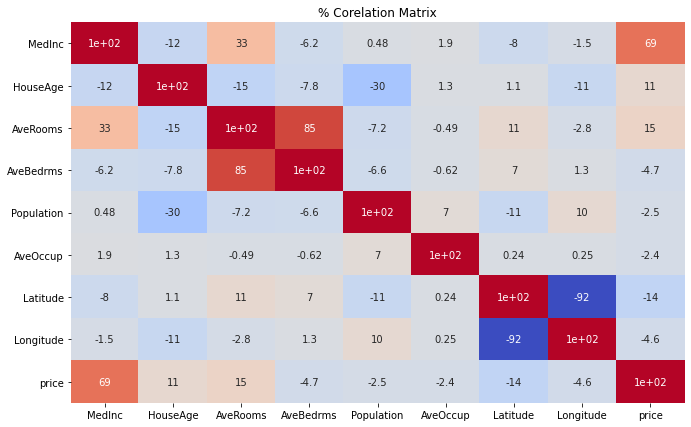

In [5]:
#corelation matrix

plt.figure(figsize=(11,7))
sns.heatmap(cbar=False,annot=True,data=california_df.corr()*100,cmap='coolwarm')
plt.title('% Corelation Matrix')
plt.show()

From the Pearson correlation between each pair of columns, we see that:

- Latitude and longitude are negatively correlated. This is logical because of California State shape. Houses seem to be parallel along the coast, so it has a negative "slope". This means that we could remove one or the other from our dataset in orden to predict house price, because they are redundant.
- Median income is highly correlated with our target value, so this means that this feature we'll have the most important role, as we'll see with feature_importance_ decission tree attribute.

## NULL AND OUTLIER EXPLORATION

### NULL EXPLORATION

In [6]:
california_df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
price         0
dtype: int64

We haven't nulls in our dataframe.

### OUTLIER DETECTION

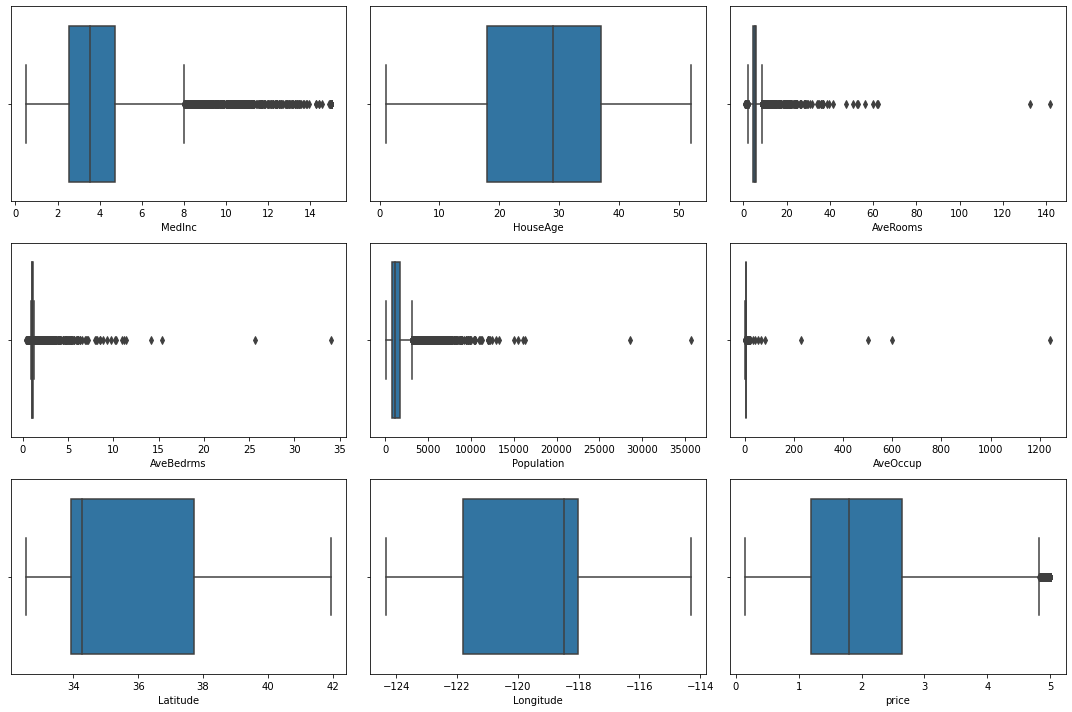

In [7]:
# Our goal here is to extract the numeric columns so we can boxplot them in order to detect outliers.

# Numeric column extraction

numeric_columns = california_df.select_dtypes(include = ['float64', 'int']).columns
len_numeric_columns = len(numeric_columns)


# Boxplotting

fig = plt.figure(figsize = (15,10))

# Set number of columns you want to plot

n_cols = 3

n_plot_rows = len_numeric_columns//n_cols
n_plot_rows


for i, column in enumerate(numeric_columns):
    ax = fig.add_subplot(n_plot_rows, n_cols, i+1)
    sns.boxplot(y = california_df[column], orient = 'h', ax = ax)

fig.tight_layout()

From the previous boxplots, we see that there are several features with outliers. These features are:

- MedInc: median income in block
- AveRooms: average number of rooms
- AveBedrms: average number of bedrooms
- Population: block population
- Price: house prices

So we should scale the data with **RobustScaler**, which uses statistics that are robust to outliers


# SPLITTING AND SCALING DATA 

In [8]:
X = california.data
y = california.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [9]:
# Because we have several features with outliers, we should scale them with RobustScaler.

rs = RobustScaler()
X_train_rs = rs.fit_transform(X_train )
X_test_rs = rs.transform(X_test)

# BUILDING OUR MACHINE LEARNING MODEL

## LINEAR REGRESSION

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Without scaling.
lg = LinearRegression()
lg.fit(X_train, y_train)

# With scaling

lg_rs = LinearRegression()
lg_rs.fit(X_train_rs, y_train)

# Obtaining prediction
y_est = lg.predict(X_test)
y_est_rs = lg_rs.predict(X_test_rs)

# Obtaining mean squared error and R2 coefficient for TESTING
MSE_tst = mean_squared_error(y_test, y_est)
R2_coeff = lg.score(X_test,y_test)

MSE_tst_rs = mean_squared_error(y_test, y_est_rs)
R2_coeff_rs = lg_rs.score(X_test_rs,y_test)


# Obtaining mean squared error and R2 coefficient FOR TRAINING
MSE_train = mean_squared_error(y_train, lg.predict(X_train))
R2_train_coeff = lg.score(X_train,y_train)



# Printing error and model precission
print('TESTING METRICS')

print('Metrics without scaling:')
print('MSE : ' + str(MSE_tst))
print('R2 score: ' + str(R2_coeff))

print('\nMetrics with RobustScaler:')
print('MSE : ' + str(MSE_tst_rs))
print('R2 score: ' + str(R2_coeff_rs))

print('\nTRAINING METRICS')

print('Metrics without scaling:')
print('MSE : ' + str(MSE_train))
print('R2 score: ' + str(R2_train_coeff))


TESTING METRICS
Metrics without scaling:
MSE : 0.5576462301494095
R2 score: 0.5823931608231574

Metrics with RobustScaler:
MSE : 0.5576462301494112
R2 score: 0.5823931608231562

TRAINING METRICS
Metrics without scaling:
MSE : 0.5110600407180694
R2 score: 0.6157129818149828


As we can see, for this problem, linear regression is not the way to go: our score is really bad. Most of our house prices range between 120K and 270K (as we see in the boxplot), so and error of 53K is really huge!!!

## KNN

Now we'll train a Nearest Neighbors algorithm with different hyperparameters. In order to do so, we'll make use of GridSearchCV function, which allow us to do a cross-validation search.

In [11]:
from sklearn.neighbors import KNeighborsRegressor


k_max =20
rang_K = np.arange(1, k_max+1)
tuned_parameters = [{'n_neighbors': rang_K}]
nfold = 5

# Grid search for finding optimal hyperparameters. We'll use two scoring methods: R2 and MSE.

neigh_CV = GridSearchCV(KNeighborsRegressor(), 
                        tuned_parameters, 
                        cv=nfold, 
                        scoring = {'MSE': make_scorer(mean_squared_error), 'R2': make_scorer(r2_score)},
                        return_train_score=True, refit = 'R2', n_jobs=-1).fit(X_train_rs, y_train)

# Obtaining prediction 
y_est = neigh_CV.predict(X_test_rs) 

# Obtaining mse and R2 coefficient
MSE_tst = mean_squared_error(y_test,y_est)
R2_coeff = neigh_CV.score(X_test_rs,y_test)

# Obtaining best params.
K_CV = neigh_CV.best_params_['n_neighbors']

print('MSE : ' + str(MSE_tst))
print('R2 score: ' + str(R2_coeff))
print('Selected value of k: ' + str(K_CV))

MSE : 0.4119422944302044
R2 score: 0.6915070698959767
Selected value of k: 15


Cross validation results:


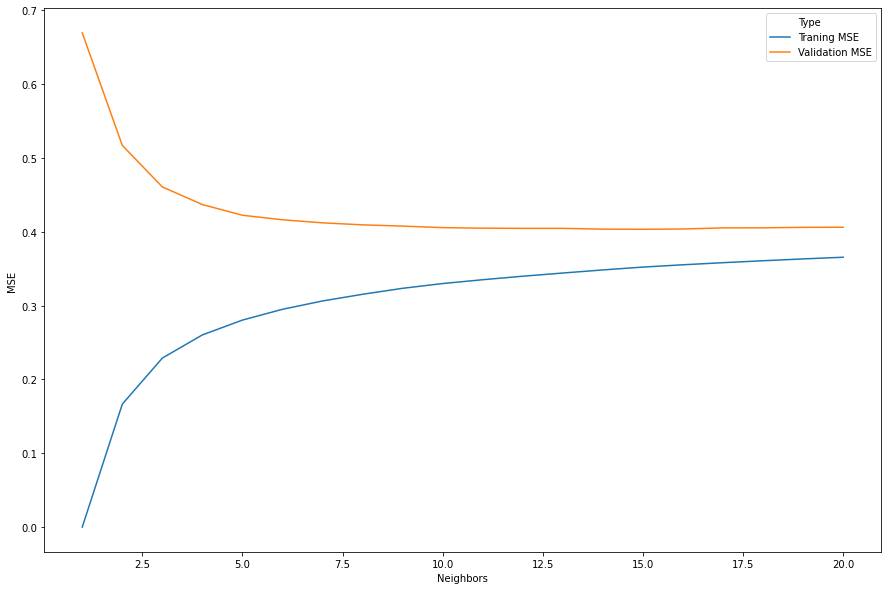

In [12]:
fig = plt.figure(figsize = (15,10))

print("Cross validation results:")
cv_results = pd.DataFrame(neigh_CV.cv_results_)
accs = pd.DataFrame(columns=["Neighbors"])

# Mostramos los resultados
melted_accs = accs.assign(**{'Neighbors': pd.DataFrame(neigh_CV.cv_results_['params']).unstack().values,
                             "Training R2": cv_results.mean_train_R2,
                             "Validation R2": cv_results.mean_test_R2,
                             "Traning MSE": cv_results.mean_train_MSE,
                             "Validation MSE": cv_results.mean_test_MSE}) \
                            .melt('Neighbors', value_vars = ['Traning MSE', 'Validation MSE'], var_name="Type", value_name="MSE")
g = sns.lineplot(x="Neighbors", y="MSE", hue='Type', data=melted_accs)

From the former graphic, we see that our model has high validation and high training errors. It suffers from high bias and low variance, underfitting the training data.

If most our house prices range between 120K and 270K, an error of 35k-45K is very significant.



## ENSEMBLES

### RANDOM FOREST

In [13]:
from sklearn.ensemble import RandomForestRegressor

nfold = 5

param_grid = [
    {'n_estimators': [3, 10, 30, 100, 150], 
    'max_features': [2, 4, 6, 8]
    },
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 100], 'max_features': [2, 3, 4]}
]

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=nfold, 
                           scoring = {'MSE': make_scorer(mean_squared_error), 'R2': make_scorer(r2_score)},
                           return_train_score=True, refit = 'R2', n_jobs=-1).fit(X_train_rs, y_train)



In [14]:
# Obtaining prediction 
y_est = grid_search.predict(X_test_rs) 
y_est_train = grid_search.predict(X_train_rs) 

# Obtaining mse and R2 coefficient for test
MSE_tst = mean_squared_error(y_test,y_est)
R2_coeff = grid_search.score(X_test_rs,y_test)

# Obtaining mse and R2 coefficient for train
MSE_train = mean_squared_error(y_train,y_est_train)
R2_coeff_train = grid_search.score(X_train_rs,y_train)

# Obtaining best params.
RF_best_params = grid_search.best_params_

print('MSE test : ' + str(MSE_tst))
print('R2 test score: ' + str(R2_coeff))

print('MSE train : ' + str(MSE_train))
print('R2 train score: ' + str(R2_coeff_train))

print('Selected value of best params: ' + str(RF_best_params))

MSE test : 0.24598501224942673
R2 test score: 0.8157881863151177
MSE train : 1.3199597829358276e-29
R2 train score: 1.0
Selected value of best params: {'bootstrap': False, 'max_features': 3, 'n_estimators': 100}


It seems that Random Forest is overfitting training data

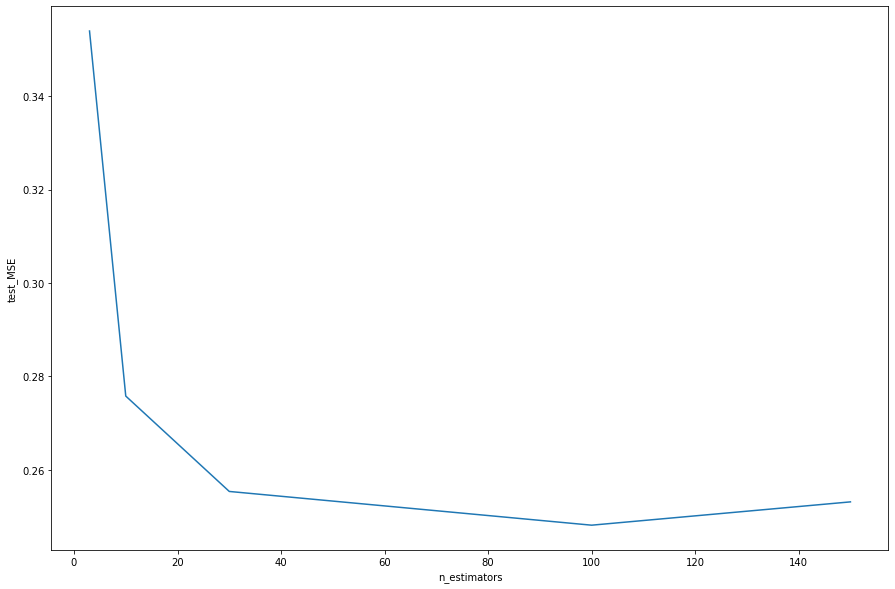

In [15]:
df_metrics = pd.concat( [pd.DataFrame(grid_search.cv_results_['params']),
            pd.DataFrame({'train_MSE': grid_search.cv_results_['mean_train_MSE']}),
            pd.DataFrame({'test_MSE': grid_search.cv_results_['mean_test_MSE']})
            ], axis = 1
            )
m = ((df_metrics.max_features == 3) & (df_metrics.bootstrap == False))
df_metrics.loc[:, ['n_estimators', 'test_MSE']]
#df_metrics = df_metrics.melt('n_estimators', value_vars = ['train_MSE', 'test_MSE'], var_name = 'Type')

fig = plt.figure(figsize = (15,10))

g = sns.lineplot(x="n_estimators", y="test_MSE", data=df_metrics, err_style = None)

Our best test performance is achieves with 100 estimators.

In [16]:
# We use this function made by Sklearn (https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)

# Graphics "Scalabilty of the model" and "Performance of the model" have been removed.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(15, 10))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")



    return plt

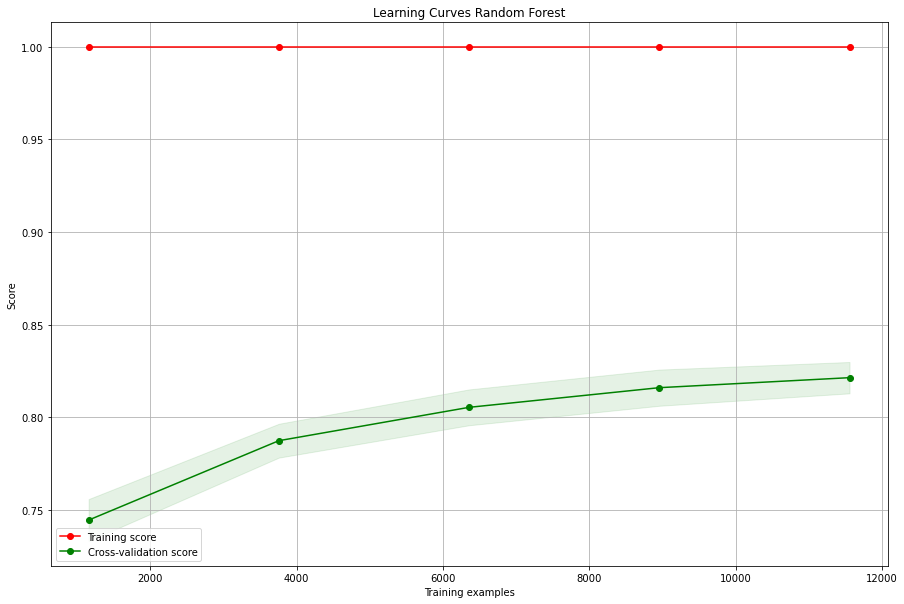

In [17]:
title = "Learning Curves Random Forest"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = grid_search.best_estimator_
plot_learning_curve(estimator, title, X_train_rs, y_train,
                    cv=cv, n_jobs=4)


plt.show()

As we've mentioned before, Random Forest is overfitting training data

### ADABOOST

In [18]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ada_reg = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=200, learning_rate=0.5 ).fit(X_train_rs, y_train)


# Obtaining prediction 
y_est = ada_reg.predict(X_test_rs) 

# Obtaining mse and R2 coefficient
MSE_tst = mean_squared_error(y_test,y_est)
R2_coeff = ada_reg.score(X_test_rs,y_test)

print('MSE : ' + str(MSE_tst))
print('R2 score: ' + str(R2_coeff))

MSE : 0.25287161313942186
R2 score: 0.8106309890189525


### GRADIENT BOOSTING

#### XGBOOST (THE WINNER)

In [19]:
#Importing xgboost regresssor
from xgboost import XGBRegressor

# In other to take a peek at the model performance and show feature importance, we'll train a simple model. Later, we'll tune hyperparameters in order
# to obtain the best model.

xg_regressor = XGBRegressor(max_depth=6, n_estimators=500, learning_rate=0.01, silent=True)
xg_regressor.fit(X_train_rs, y_train)

print('Feature importance:')
for name, score in zip(california['feature_names'], xg_regressor.feature_importances_):
  print(name, '{0:.2f} %'.format(score*100))

print('\n'*2, 'Scoring:')
print('MSE for test {0:.2f}'.format(mean_squared_error(y_test, xg_regressor.predict(X_test_rs))))
print('R-squared for test {0:.2f}'.format(xg_regressor.score(X_test_rs, y_test)))
print('MSE for train {0:.2f}'.format(mean_squared_error(y_train, xg_regressor.predict(X_train_rs))))
print('R-squared for train {0:.2f}'.format(xg_regressor.score(X_train_rs, y_train)))

[08:52:55] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Feature importance:
MedInc 58.18 %
HouseAge 6.10 %
AveRooms 4.12 %
AveBedrms 2.04 %
Population 1.73 %
AveOccup 15.32 %
Latitude 6.25 %
Longitude 6.24 %


 Scoring:
MSE for test 0.27
R-squared for test 0.80
MSE for train 0.18
R-squared for train 0.87


##### HYPERPARAMETER TUNING

We'll use RandomizedSearchCV, which has the advantage that, instead of trying all combination of the hyperparameters grid with each KFOLD CV, it picks ramdom combinations. This way, we can have a notion of the best hyperparameters so we can center ranges in our GridSearch (but we'll not use it because of computational capacity).

In [20]:
# A parameter grid for XGBoost
params = {
        'n_estimators':[100,150,200,300,350],
        'learning_rate': np.linspace(0.1, 1.0, 10),
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': np.arange(3,11,1),
        }


We have in total 5 * 10 * 3 * 6 * 3 * 3 * 7 = 56.700 combinations. That's why we choose RamdomizedSearch over GridSearch in first place. It would take a lot of time to try all these combinations.

In [21]:
from sklearn.model_selection import RandomizedSearchCV


xgb_reg = XGBRegressor(silent=True)


xgb_random = RandomizedSearchCV(estimator = xgb_reg, param_distributions = params, n_iter = 200, cv = 5, verbose=0,  
                                scoring = {'MSE': make_scorer(mean_squared_error), 'R2': make_scorer(r2_score)},
                                return_train_score=True, refit = 'R2', n_jobs=-1).fit(X_train_rs, y_train)




[09:12:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [22]:


# Obtaining prediction 
y_est = xgb_random.predict(X_test_rs) 
y_est_train = xgb_random.predict(X_train_rs) 

# Obtaining mse and R2 coefficient for test
MSE_tst = mean_squared_error(y_test,y_est)
R2_coeff = xgb_random.score(X_test_rs,y_test)

# Obtaining mse and R2 coefficient for train
MSE_train = mean_squared_error(y_train,y_est_train)
R2_coeff_train = xgb_random.score(X_train_rs,y_train)

# Obtaining best params.
RF_best_params = xgb_random.best_params_

print('MSE test : ' + str(MSE_tst))
print('R2 test score: ' + str(R2_coeff))

print('MSE train : ' + str(MSE_train))
print('R2 train score: ' + str(R2_coeff_train))

print('Selected value of best params: ' + str(RF_best_params))

MSE test : 0.21834276168162908
R2 test score: 0.8364887528450115
MSE train : 0.03996817480620224
R2 train score: 0.9699462890955193
Selected value of best params: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


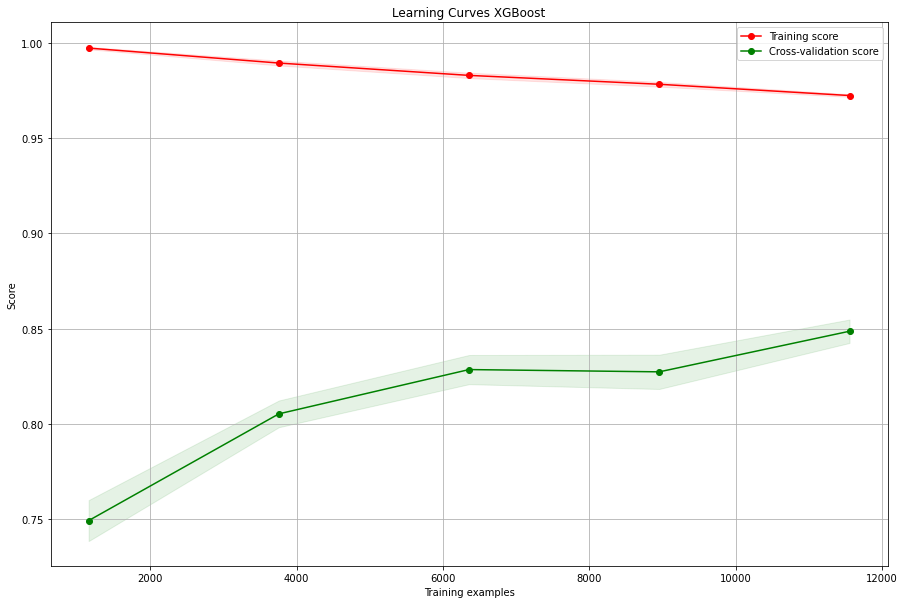

In [23]:
title = "Learning Curves XGBoost"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = xgb_random.best_estimator_
plot_learning_curve(estimator, title, X_train_rs, y_train,
                    cv=cv, n_jobs=-1)


plt.show()

There seem to be a little bit of overfitting, but not as much as Random forest. We can remove overfitting by selecting only the most important features or by early stoping. We'll try removing features.

In [24]:
print('Feature importance:')
for name, score in zip(california['feature_names'], xgb_random.best_estimator_.feature_importances_):
  print(name, '{0:.2f} %'.format(score*100))

Feature importance:
MedInc 36.41 %
HouseAge 8.17 %
AveRooms 9.93 %
AveBedrms 4.16 %
Population 3.73 %
AveOccup 10.60 %
Latitude 13.98 %
Longitude 13.02 %


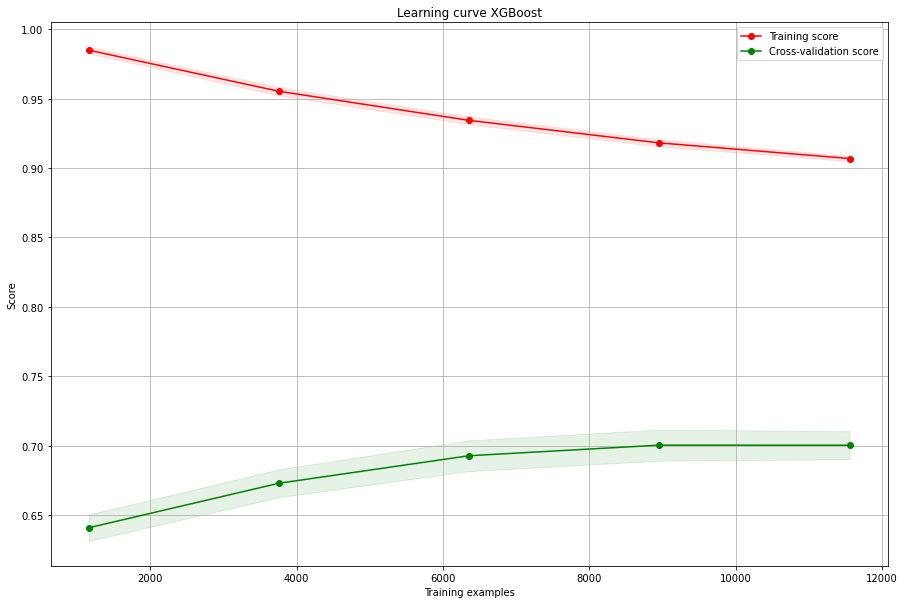

In [25]:
#We select the most important features

X_train_less_features = X_train_rs[:,[0,2,5,7]]

title = "Learning curve XGBoost"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = xgb_random.best_estimator_
plot_learning_curve(estimator, title, X_train_less_features, y_train,
                    cv=cv, n_jobs=-1)


plt.show()

**Removing features reduces our valdation score very badly**. So we choose the model given by RandomizedSearch CV with a R2 test score of 0.849 and these params:

- 'subsample': 1.0, 
- 'n_estimators': 300
- 'min_child_weight': 5
- 'max_depth': 8 
- 'learning_rate': 0.1 
- 'gamma': 0 
- 'colsample_bytree': 0.8